In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
# from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint
from model import ODEBlock
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = ("cpu")
device

device(type='cuda', index=0)

In [3]:
# load the dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X_Faultline110112.pth")
Generator_nodes = np.load("./data/Generator_nodes.npy")

# Training

iteration: [10/1000], training loss: 0.001828
iteration: [20/1000], training loss: 0.001078
iteration: [30/1000], training loss: 0.000811
iteration: [40/1000], training loss: 0.000592
iteration: [50/1000], training loss: 0.000853
iteration: [60/1000], training loss: 0.000645
iteration: [70/1000], training loss: 0.000409
iteration: [80/1000], training loss: 0.000300
iteration: [90/1000], training loss: 0.000220
iteration: [100/1000], training loss: 0.000161
iteration: [110/1000], training loss: 0.000114
iteration: [120/1000], training loss: 0.000126
iteration: [130/1000], training loss: 0.000095
iteration: [140/1000], training loss: 0.000074
iteration: [150/1000], training loss: 0.000057
iteration: [160/1000], training loss: 0.000047
iteration: [170/1000], training loss: 0.000038
iteration: [180/1000], training loss: 0.000033
iteration: [190/1000], training loss: 0.000037
iteration: [200/1000], training loss: 0.000025
iteration: [210/1000], training loss: 0.000021
iteration: [220/1000],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iteration: [1000/1000], training loss: 0.000001


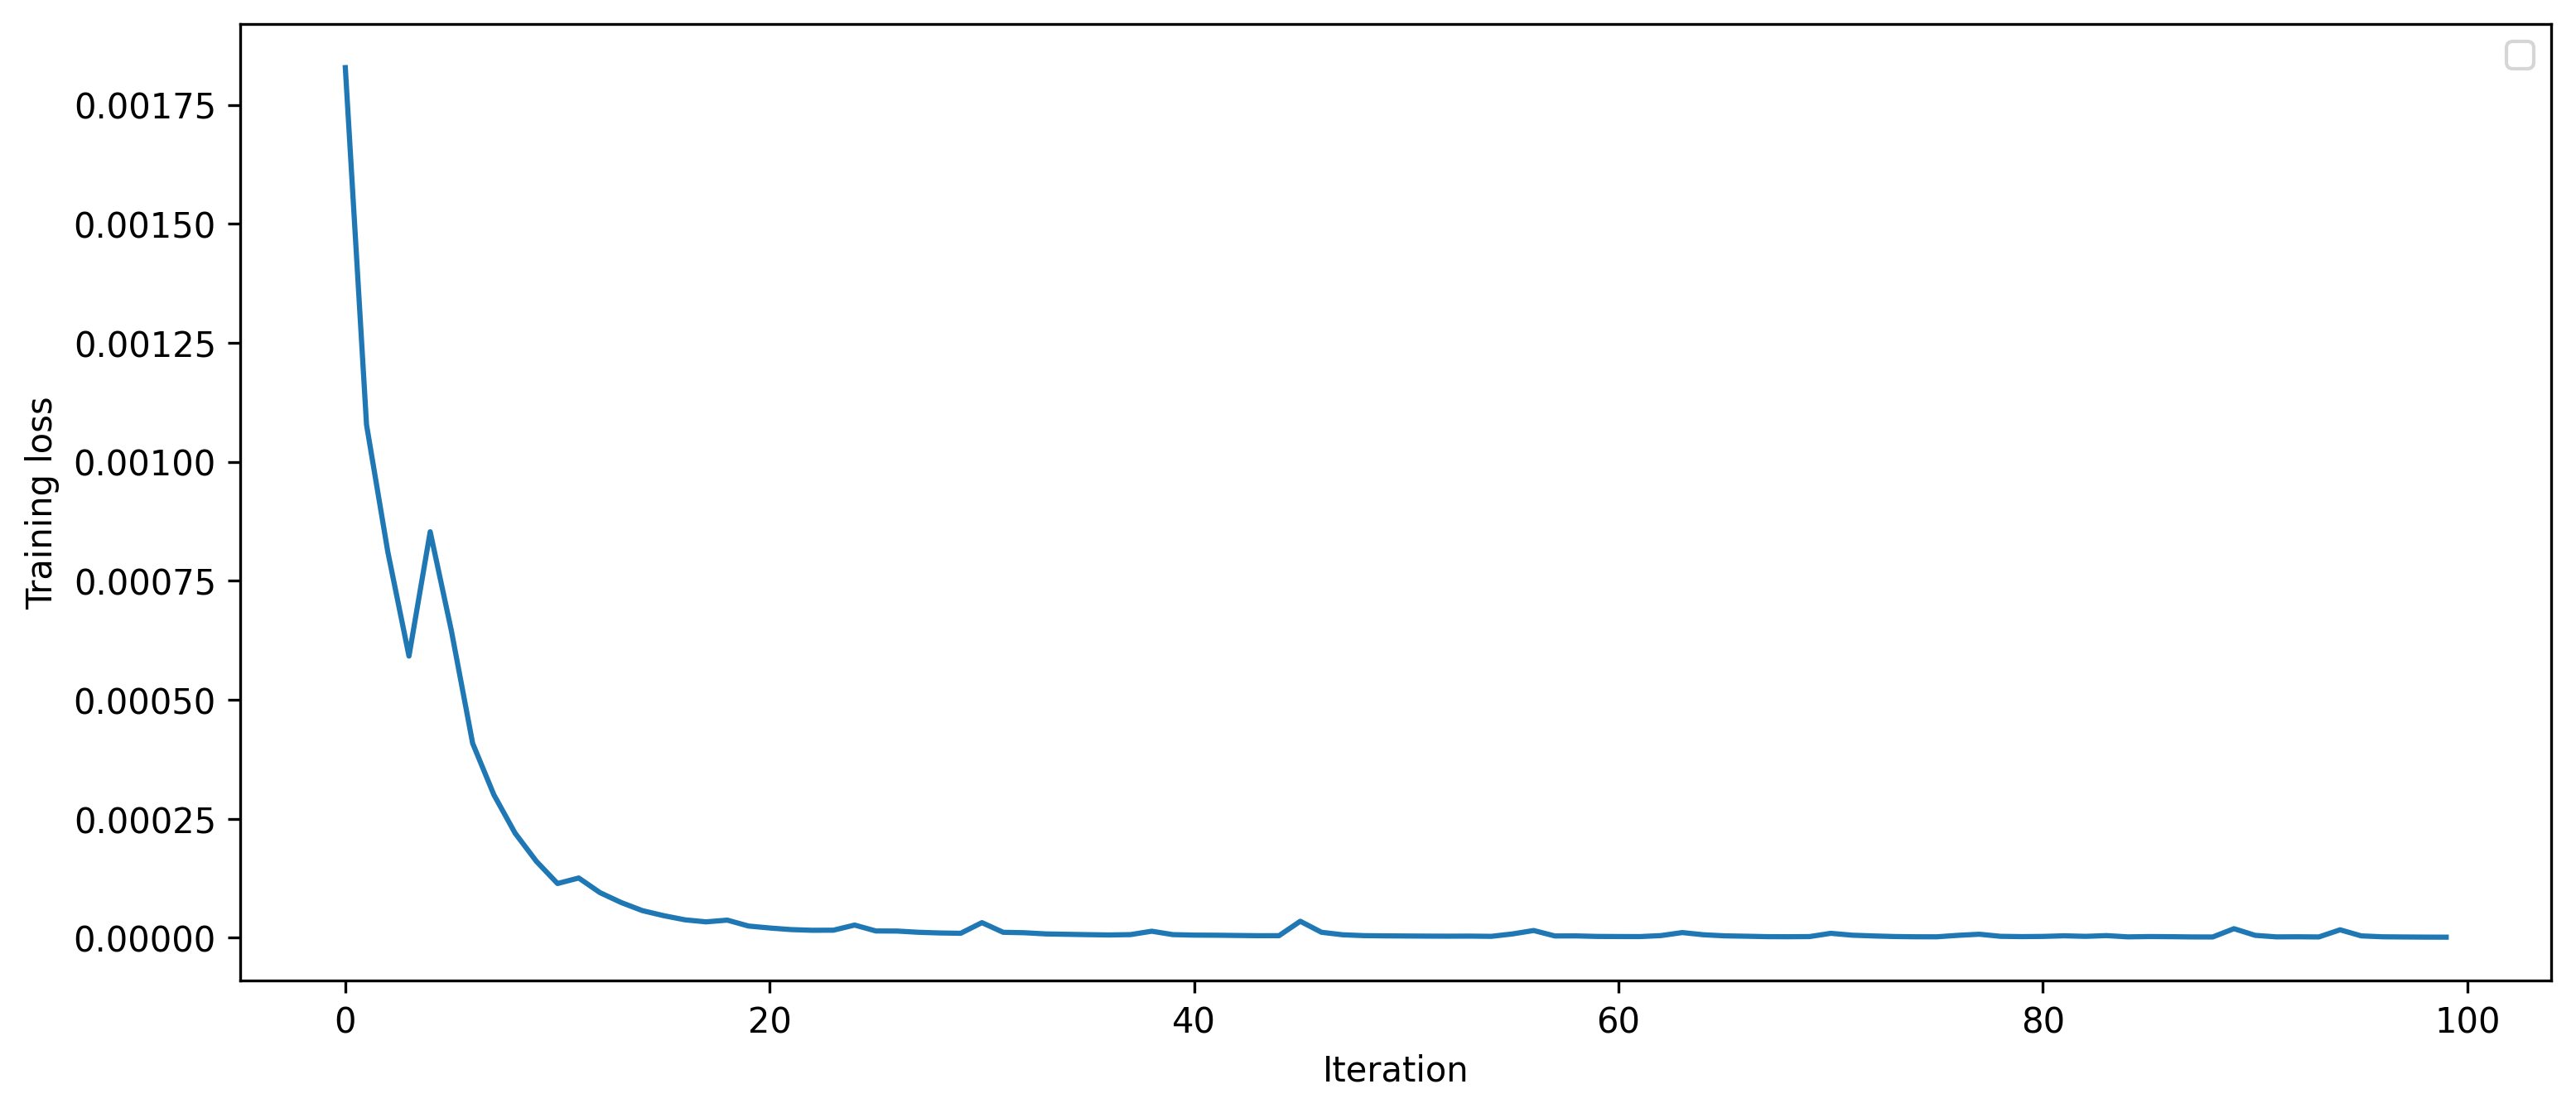

In [4]:
t_eval = t
X_train = X
# parameters
num_traj = X_train.shape[0]
data_size = X_train.shape[1]
batch_time = 10
batch_size = 256
dim = X_train.shape[-1]

def get_batch(dataset, t):
    Batch_y0 = torch.Tensor()
    Batch_y = torch.Tensor()
    for ii in range(num_traj):
        true_y = dataset[ii]
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=True))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        Batch_y0 = torch.cat((Batch_y0, batch_y0), dim=-2)
        Batch_y = torch.cat((Batch_y, batch_y), dim=-2)
    # return Batch_y0, batch_t, Batch_y
    return Batch_y0.to(device), batch_t.to(device), Batch_y.to(device)

batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)
model = ODEBlock(dim,1000,dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
ITRs = 1000

Loss_train = []
Loss_test = []
for i in range(ITRs):
    batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)
    optimizer.zero_grad()
    batch_y_hat = odeint(model, batch_y0, batch_t, atol=1e-6)
    loss = criterion(batch_y_hat, batch_y)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        Loss_train.append(loss.item())
        print(f'iteration: [{i+1}/{ITRs}], training loss: {loss.item():.6f}')

plt.figure(figsize=(12,5), dpi=300)
plt.plot(range(len(Loss_train)), Loss_train)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()
torch.save(model.state_dict(), './result/model/ODEBlock_Faultline110112.pth')